# Visual Transformer

Training Visual Transformer on *Dogs vs Cats Data*

## Import Libraries  

In [1]:
from __future__ import print_function

import glob
from itertools import chain
import os
import random
import zipfile
import shutil

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from PIL import Image, UnidentifiedImageError
from sklearn.model_selection import train_test_split
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from tqdm.notebook import tqdm

import sys
sys.path.append("../model")  # 添加 model 目录到系统路径

from model import ViT

In [2]:
print(f"Torch: {torch.__version__}")

Torch: 2.6.0+cu126


In [3]:
# Training settings
batch_size = 64
epochs = 50
lr = 3e-5
gamma = 0.7
seed = 42

In [4]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

seed_everything(seed)

In [5]:
device = 'cuda'

## Load Data

In [6]:
os.makedirs('data', exist_ok=True)

In [7]:
train_dir = 'data/train'
test_dir = 'data/test'

In [8]:
# """
# 准备数据集脚本

# 【使用前提】

# 1. 当前目录下必须有一个名为 "data" 的文件夹
# 2. "data" 文件夹下必须有两个子文件夹，分别是：
#     - data/cat/
#     - data/dog/

# 每个文件夹内应是按顺序命名的图片（jpg/png等格式）

# 3. 数据可以从以下网址下载（提供示例数据集）：
#    https://www.microsoft.com/en-us/download/details.aspx?id=54765
#    下载后，提取并按上述结构放置好。

# 【脚本功能】

# - 将 cat 和 dog 的图片按 80%/20% 的比例划分为 train 和 test
# - 并重命名为 cat.0.jpg、dog.0.jpg 格式
# - 原始的 cat 和 dog 文件夹将被删除
# """
# # 源目录
# src_dir = "data"

# # 目标目录（train/test）
# splits = ["train", "test"]
# split_ratios = [0.8, 0.2]  # 80% train，20% test

# # 允许的图片格式
# image_extensions = [".jpg", ".jpeg", ".png", ".bmp", ".gif"]

# for split in splits:
#     os.makedirs(os.path.join(src_dir, split), exist_ok=True)

# # 处理 cat 和 dog
# for cls in ["cat", "dog"]:
#     cls_dir = os.path.join(src_dir, cls)

#     # 只收集图片文件
#     files = [
#         f for f in os.listdir(cls_dir)
#         if os.path.isfile(os.path.join(cls_dir, f)) and os.path.splitext(f)[1].lower() in image_extensions
#     ]
    
#     random.shuffle(files)

#     total = len(files)
#     train_num = int(total * split_ratios[0])

#     split_files = {
#         "train": files[:train_num],
#         "test": files[train_num:]
#     }

#     # 复制文件到对应目录 + 重命名
#     for split, file_list in split_files.items():
#         for idx, file in enumerate(file_list):
#             src_file = os.path.join(cls_dir, file)

#             # 重命名格式 cat.0.jpg / dog.0.jpg
#             ext = os.path.splitext(file)[1]
#             new_filename = f"{cls}.{idx}{ext}"

#             dst_file = os.path.join(src_dir, split, new_filename)

#             shutil.copy2(src_file, dst_file)

# # 删除原来的 cat 和 dog 目录
# for cls in ["cat", "dog"]:
#     cls_dir = os.path.join(src_dir, cls)
#     shutil.rmtree(cls_dir)

# print("数据划分、重命名和目录删除完成！")

In [9]:
train_list = glob.glob(os.path.join(train_dir,'*.jpg'))
test_list = glob.glob(os.path.join(test_dir, '*.jpg'))

In [10]:
print(f"Train Data: {len(train_list)}")
print(f"Test Data: {len(test_list)}")

Train Data: 19998
Test Data: 5000


In [11]:
labels = [path.split('/')[-1].split('.')[0] for path in train_list]

## Random Plots

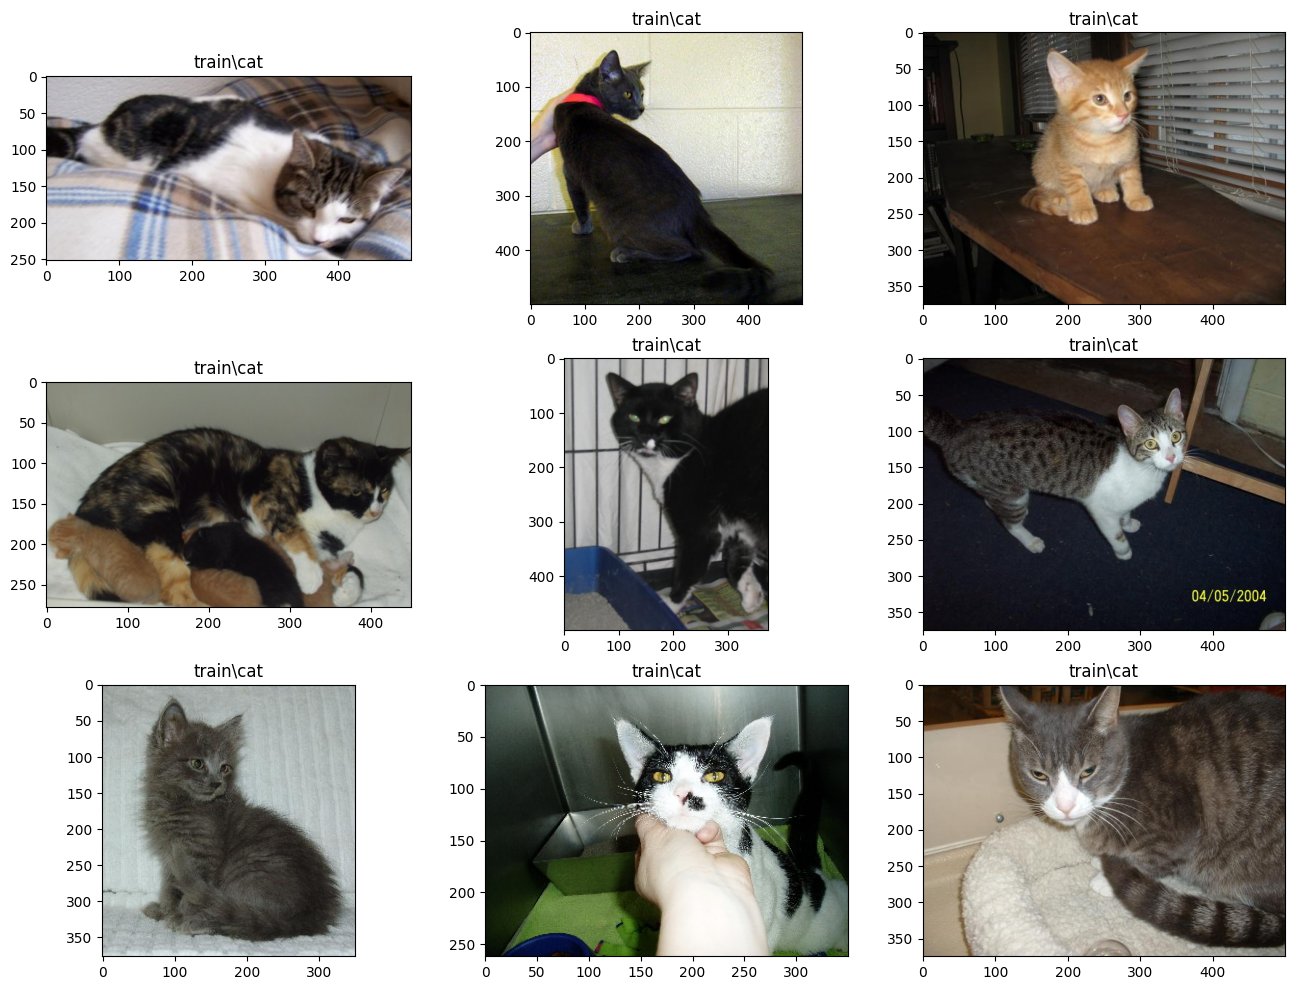

In [12]:
random_idx = np.random.randint(1, len(train_list), size=9)
fig, axes = plt.subplots(3, 3, figsize=(16, 12))

for idx, ax in enumerate(axes.ravel()):
    img = Image.open(train_list[idx])
    ax.set_title(labels[idx])
    ax.imshow(img)


## Split

In [13]:
train_list, valid_list = train_test_split(train_list, 
                                          test_size=0.2,
                                          stratify=labels,
                                          random_state=seed)

In [14]:
print(f"Train Data: {len(train_list)}")
print(f"Validation Data: {len(valid_list)}")
print(f"Test Data: {len(test_list)}")

Train Data: 15998
Validation Data: 4000
Test Data: 5000


## Image Augmentation

In [15]:
train_transforms = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ]
)

val_transforms = transforms.Compose(
    [
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
    ]
)


test_transforms = transforms.Compose(
    [
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
    ]
)


## Load Datasets

In [16]:
class CatsDogsDataset(Dataset):
    def __init__(self, file_list, transform=None):
        self.file_list = file_list
        self.transform = transform

    def __len__(self):
        self.filelength = len(self.file_list)
        return self.filelength

    def __getitem__(self, idx):
        img_path = self.file_list[idx]
        try:
            img = Image.open(img_path).convert("RGB")
        except UnidentifiedImageError:
            print(f"Warning: Cannot identify image file {img_path}, skipping.")
            # 递归调用下一个样本（简单处理方案，不影响 batch size）
            return self.__getitem__((idx + 1) % len(self))
        img_transformed = self.transform(img)

        label = os.path.basename(img_path).split(".")[0]
        label = 1 if label == "dog" else 0

        return img_transformed, label


In [17]:
train_data = CatsDogsDataset(train_list, transform=train_transforms)
valid_data = CatsDogsDataset(valid_list, transform=test_transforms)
test_data = CatsDogsDataset(test_list, transform=test_transforms)

In [18]:
train_loader = DataLoader(dataset = train_data, batch_size=batch_size, shuffle=True )
valid_loader = DataLoader(dataset = valid_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset = test_data, batch_size=batch_size, shuffle=True)

In [19]:
print(len(train_data), len(train_loader))

15998 250


In [20]:
print(len(valid_data), len(valid_loader))

4000 63


## Efficient Attention

### Visual Transformer

In [21]:
model = ViT(
    image_size=224,
    patch_size=16,
    num_classes=2,   
    dim=768,
    depth=5,
    heads=12,
    mlp_dim=768*4,  # 可以是 4xdim
).to(device)

### Training
[Adam Optimizer](https://arxiv.org/pdf/1412.6980)

In [22]:
# loss function
criterion = nn.CrossEntropyLoss()
# optimizer 
optimizer = optim.Adam(model.parameters(), lr=lr)
# scheduler
scheduler = StepLR(optimizer, step_size=1, gamma=gamma)

In [23]:
for epoch in range(epochs):
    epoch_loss = 0
    epoch_accuracy = 0

    for data, label in tqdm(train_loader):
        data = data.to(device)
        label = label.to(device)

        output = model(data)
        loss = criterion(output, label)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        acc = (output.argmax(dim=1) == label).float().mean()
        epoch_accuracy += acc / len(train_loader)
        epoch_loss += loss / len(train_loader)

    with torch.no_grad():
        epoch_val_accuracy = 0
        epoch_val_loss = 0
        for data, label in valid_loader:
            data = data.to(device)
            label = label.to(device)

            val_output = model(data)
            val_loss = criterion(val_output, label)

            acc = (val_output.argmax(dim=1) == label).float().mean()
            epoch_val_accuracy += acc / len(valid_loader)
            epoch_val_loss += val_loss / len(valid_loader)

    print(
        f"Epoch : {epoch+1} - loss : {epoch_loss:.4f} - acc: {epoch_accuracy:.4f} - val_loss : {epoch_val_loss:.4f} - val_acc: {epoch_val_accuracy:.4f}\n"
    )


  0%|          | 0/250 [00:00<?, ?it/s]

C:\Users\61728\miniconda3\envs\pytorch_env\Lib\site-packages\PIL\TiffImagePlugin.py:935: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Epoch : 1 - loss : 0.6954 - acc: 0.5461 - val_loss : 0.6836 - val_acc: 0.5464



  0%|          | 0/250 [00:00<?, ?it/s]

Epoch : 2 - loss : 0.6409 - acc: 0.6231 - val_loss : 0.5988 - val_acc: 0.6721



  0%|          | 0/250 [00:00<?, ?it/s]

Epoch : 3 - loss : 0.6066 - acc: 0.6650 - val_loss : 0.5494 - val_acc: 0.7180



  0%|          | 0/250 [00:00<?, ?it/s]

Epoch : 4 - loss : 0.5862 - acc: 0.6896 - val_loss : 0.5461 - val_acc: 0.7279



  0%|          | 0/250 [00:00<?, ?it/s]

Epoch : 5 - loss : 0.5641 - acc: 0.7016 - val_loss : 0.5261 - val_acc: 0.7292



  0%|          | 0/250 [00:00<?, ?it/s]

Epoch : 6 - loss : 0.5508 - acc: 0.7162 - val_loss : 0.4957 - val_acc: 0.7540



  0%|          | 0/250 [00:00<?, ?it/s]

Epoch : 7 - loss : 0.5460 - acc: 0.7233 - val_loss : 0.5048 - val_acc: 0.7500



  0%|          | 0/250 [00:00<?, ?it/s]

Epoch : 8 - loss : 0.5315 - acc: 0.7285 - val_loss : 0.5244 - val_acc: 0.7319



  0%|          | 0/250 [00:00<?, ?it/s]

Epoch : 9 - loss : 0.5247 - acc: 0.7341 - val_loss : 0.4761 - val_acc: 0.7731



  0%|          | 0/250 [00:00<?, ?it/s]

Epoch : 10 - loss : 0.5204 - acc: 0.7364 - val_loss : 0.4681 - val_acc: 0.7731



  0%|          | 0/250 [00:00<?, ?it/s]

Epoch : 11 - loss : 0.5178 - acc: 0.7364 - val_loss : 0.4825 - val_acc: 0.7622



  0%|          | 0/250 [00:00<?, ?it/s]

Epoch : 12 - loss : 0.5135 - acc: 0.7400 - val_loss : 0.4691 - val_acc: 0.7679



  0%|          | 0/250 [00:00<?, ?it/s]

Epoch : 13 - loss : 0.5015 - acc: 0.7487 - val_loss : 0.4503 - val_acc: 0.7875



  0%|          | 0/250 [00:00<?, ?it/s]

Epoch : 14 - loss : 0.4999 - acc: 0.7516 - val_loss : 0.4576 - val_acc: 0.7845



  0%|          | 0/250 [00:00<?, ?it/s]

Epoch : 15 - loss : 0.4925 - acc: 0.7575 - val_loss : 0.4452 - val_acc: 0.7865



  0%|          | 0/250 [00:00<?, ?it/s]

Epoch : 16 - loss : 0.4911 - acc: 0.7599 - val_loss : 0.4262 - val_acc: 0.8078



  0%|          | 0/250 [00:00<?, ?it/s]

Epoch : 17 - loss : 0.4889 - acc: 0.7571 - val_loss : 0.4223 - val_acc: 0.8043



  0%|          | 0/250 [00:00<?, ?it/s]

Epoch : 18 - loss : 0.4821 - acc: 0.7668 - val_loss : 0.4177 - val_acc: 0.8053



  0%|          | 0/250 [00:00<?, ?it/s]

Epoch : 19 - loss : 0.4844 - acc: 0.7598 - val_loss : 0.4179 - val_acc: 0.8056



  0%|          | 0/250 [00:00<?, ?it/s]

Epoch : 20 - loss : 0.4794 - acc: 0.7652 - val_loss : 0.4167 - val_acc: 0.8063



  0%|          | 0/250 [00:00<?, ?it/s]

Epoch : 21 - loss : 0.4787 - acc: 0.7667 - val_loss : 0.4146 - val_acc: 0.8070



  0%|          | 0/250 [00:00<?, ?it/s]

Epoch : 22 - loss : 0.4708 - acc: 0.7691 - val_loss : 0.4169 - val_acc: 0.8113



  0%|          | 0/250 [00:00<?, ?it/s]

Epoch : 23 - loss : 0.4597 - acc: 0.7778 - val_loss : 0.4094 - val_acc: 0.8105



  0%|          | 0/250 [00:00<?, ?it/s]

Epoch : 24 - loss : 0.4613 - acc: 0.7771 - val_loss : 0.4002 - val_acc: 0.8167



  0%|          | 0/250 [00:00<?, ?it/s]

Epoch : 25 - loss : 0.4532 - acc: 0.7790 - val_loss : 0.4038 - val_acc: 0.8172



  0%|          | 0/250 [00:00<?, ?it/s]

Epoch : 26 - loss : 0.4497 - acc: 0.7837 - val_loss : 0.4027 - val_acc: 0.8132



  0%|          | 0/250 [00:00<?, ?it/s]

Epoch : 27 - loss : 0.4511 - acc: 0.7846 - val_loss : 0.3928 - val_acc: 0.8180



  0%|          | 0/250 [00:00<?, ?it/s]

Epoch : 28 - loss : 0.4451 - acc: 0.7850 - val_loss : 0.3847 - val_acc: 0.8304



  0%|          | 0/250 [00:00<?, ?it/s]

Epoch : 29 - loss : 0.4553 - acc: 0.7786 - val_loss : 0.3844 - val_acc: 0.8254



  0%|          | 0/250 [00:00<?, ?it/s]

Epoch : 30 - loss : 0.4415 - acc: 0.7887 - val_loss : 0.3804 - val_acc: 0.8259



  0%|          | 0/250 [00:00<?, ?it/s]

Epoch : 31 - loss : 0.4513 - acc: 0.7835 - val_loss : 0.4336 - val_acc: 0.7961



  0%|          | 0/250 [00:00<?, ?it/s]

Epoch : 32 - loss : 0.4379 - acc: 0.7919 - val_loss : 0.3926 - val_acc: 0.8209



  0%|          | 0/250 [00:00<?, ?it/s]

Epoch : 33 - loss : 0.4385 - acc: 0.7917 - val_loss : 0.3854 - val_acc: 0.8266



  0%|          | 0/250 [00:00<?, ?it/s]

Epoch : 34 - loss : 0.4384 - acc: 0.7899 - val_loss : 0.3798 - val_acc: 0.8281



  0%|          | 0/250 [00:00<?, ?it/s]

Epoch : 35 - loss : 0.4318 - acc: 0.7921 - val_loss : 0.3730 - val_acc: 0.8341



  0%|          | 0/250 [00:00<?, ?it/s]

Epoch : 36 - loss : 0.4316 - acc: 0.7962 - val_loss : 0.3671 - val_acc: 0.8393



  0%|          | 0/250 [00:00<?, ?it/s]

Epoch : 37 - loss : 0.4294 - acc: 0.7972 - val_loss : 0.3702 - val_acc: 0.8361



  0%|          | 0/250 [00:00<?, ?it/s]

Epoch : 38 - loss : 0.4187 - acc: 0.8024 - val_loss : 0.3600 - val_acc: 0.8390



  0%|          | 0/250 [00:00<?, ?it/s]

Epoch : 39 - loss : 0.4252 - acc: 0.8022 - val_loss : 0.3774 - val_acc: 0.8276



  0%|          | 0/250 [00:00<?, ?it/s]

Epoch : 40 - loss : 0.4260 - acc: 0.7984 - val_loss : 0.3965 - val_acc: 0.8140



  0%|          | 0/250 [00:00<?, ?it/s]

Epoch : 41 - loss : 0.4186 - acc: 0.8054 - val_loss : 0.3801 - val_acc: 0.8286



  0%|          | 0/250 [00:00<?, ?it/s]

Epoch : 42 - loss : 0.4229 - acc: 0.8000 - val_loss : 0.3854 - val_acc: 0.8222



  0%|          | 0/250 [00:00<?, ?it/s]

Epoch : 43 - loss : 0.4124 - acc: 0.8052 - val_loss : 0.3584 - val_acc: 0.8301



  0%|          | 0/250 [00:00<?, ?it/s]

Epoch : 44 - loss : 0.4079 - acc: 0.8110 - val_loss : 0.3528 - val_acc: 0.8395



  0%|          | 0/250 [00:00<?, ?it/s]

Epoch : 45 - loss : 0.4110 - acc: 0.8067 - val_loss : 0.3714 - val_acc: 0.8289



  0%|          | 0/250 [00:00<?, ?it/s]

Epoch : 46 - loss : 0.4038 - acc: 0.8106 - val_loss : 0.3644 - val_acc: 0.8363



  0%|          | 0/250 [00:00<?, ?it/s]

Epoch : 47 - loss : 0.4012 - acc: 0.8130 - val_loss : 0.3513 - val_acc: 0.8383



  0%|          | 0/250 [00:00<?, ?it/s]

Epoch : 48 - loss : 0.4010 - acc: 0.8133 - val_loss : 0.3362 - val_acc: 0.8512



  0%|          | 0/250 [00:00<?, ?it/s]

Epoch : 49 - loss : 0.4029 - acc: 0.8102 - val_loss : 0.3633 - val_acc: 0.8326



  0%|          | 0/250 [00:00<?, ?it/s]

Epoch : 50 - loss : 0.4048 - acc: 0.8082 - val_loss : 0.3372 - val_acc: 0.8470



In [24]:
 with torch.no_grad():
     test_accuracy = 0
     for data, label in test_loader:
         data = data.to(device)
         label = label.to(device)
         
         test_output = model(data)
         test_loss = criterion(test_output, label)
         
         acc = (test_output.argmax(dim=1) == label).float().mean()
         test_accuracy += acc / len(test_loader)
     print(f"test acc: {test_accuracy:.4f}")

test acc: 0.8501
